In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

# Import Ngl with pyn_env active 
# import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



## Read in data

In [2]:
dataDir   = '/glade/work/mdfowler/gust_cam7/output/'

file_ctrl = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.02-11_1dVars.nc'
file_gust = 'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h0.02-11_1dVars.nc'

with xr.open_dataset(dataDir+file_ctrl, decode_times=True) as ctrlDS:
    ctrlDS['time'] = ctrlDS.time.values - timedelta(days = 15) 
    
with xr.open_dataset(dataDir+file_gust, decode_times=True) as gustDS:
    gustDS['time'] = gustDS.time.values - timedelta(days = 15) 

## Add PRECT variable to monthly datasets 
ctrlDS['PRECT']  = ( ('time','lat','lon'), ( ctrlDS['PRECC']+ctrlDS['PRECL'] ) )                              
ctrlDS['PRECT'].attrs['units']   = ctrlDS['PRECC'].units
ctrlDS['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'

gustDS['PRECT']  = ( ('time','lat','lon'), ( gustDS['PRECC']+gustDS['PRECL'] ) )                              
gustDS['PRECT'].attrs['units']   = gustDS['PRECC'].units
gustDS['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'


In [3]:
## May want to consider limiting the years of the 32L run to match the 58L one... 

iyears = np.where(ctrlDS['time.year']<=6)[0]
ctrlDS = ctrlDS.isel(time=iyears)
gustDS = gustDS.isel(time=iyears)


In [4]:
dataDir   = '/glade/work/mdfowler/gust_cam7/output/'

file_ctrl58 = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.002.cam.h0.02-06_1dVars.nc'
file_gust58 = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_58L.002.cam.h0.02-06_1dVars.nc'

with xr.open_dataset(dataDir+file_ctrl58, decode_times=True) as ctrl58:
    ctrl58['time'] = ctrl58.time.values - timedelta(days = 15) 
    
with xr.open_dataset(dataDir+file_gust58, decode_times=True) as gust58:
    gust58['time'] = gust58.time.values - timedelta(days = 15) 

## Add PRECT variable to monthly datasets 
ctrl58['PRECT']                      = ( ('time','lat','lon'), ( ctrl58['PRECC']+ctrl58['PRECL'] ) )                              
ctrl58['PRECT'].attrs['units']       = ctrl58['PRECC'].units
ctrl58['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'

gust58['PRECT']                      = ( ('time','lat','lon'), ( gust58['PRECC']+gust58['PRECL'] ) )                              
gust58['PRECT'].attrs['units']       = gust58['PRECC'].units
gust58['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'


In [5]:
dataDir   = '/glade/work/mdfowler/gust_cam7/output/'

file_ctrl58fv = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001.cam.h0.02-06_1dVars.nc'
file_gust58fv = 'F2010climo.f09_f09_mg17.TestGustGlobal_58L.001.cam.h0.02-06_1dVars.nc'

with xr.open_dataset(dataDir+file_ctrl58fv, decode_times=True) as ctrl58fv:
    ctrl58fv['time'] = ctrl58fv.time.values - timedelta(days = 15) 
    
with xr.open_dataset(dataDir+file_gust58fv, decode_times=True) as gust58fv:
    gust58fv['time'] = gust58fv.time.values - timedelta(days = 15) 

## Add PRECT variable to monthly datasets 
ctrl58fv['PRECT']                      = ( ('time','lat','lon'), ( ctrl58fv['PRECC']+ctrl58fv['PRECL'] ) )                              
ctrl58fv['PRECT'].attrs['units']       = ctrl58fv['PRECC'].units
ctrl58fv['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'

gust58fv['PRECT']                      = ( ('time','lat','lon'), ( gust58fv['PRECC']+gust58fv['PRECL'] ) )                              
gust58fv['PRECT'].attrs['units']       = gust58fv['PRECC'].units
gust58fv['PRECT'].attrs['long_name']   = 'Total Precipitation Rate (PRECL+PRECC)'


In [6]:
## Also get land frac 
with xr.open_dataset(dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h0.0011-12_LANDFRAC.nc') as fracDS: 
    landFrac = np.squeeze(fracDS.LANDFRAC.values[0,:,:])

with xr.open_dataset(dataDir+'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.002.cam.h0.0005-06_LANDFRAC.nc') as frac58: 
    landFrac58 = np.squeeze(frac58.LANDFRAC.values[0,:,:])
    

In [7]:
# Create land/ocean mask 
landMask = np.zeros(np.shape(landFrac))
landMask[np.where(landFrac>0.0)]  = 1.0
landMask[np.where(landMask==0.0)] = np.nan

oceanMask = np.ones(np.shape(landFrac))
oceanMask[np.where(landFrac>0.0)]   = 0.0
oceanMask[np.where(oceanMask==0.0)] = np.nan


In [8]:
# Create land/ocean mask 
landMask58 = np.zeros(np.shape(landFrac58))
landMask58[np.where(landFrac58>0.0)]  = 1.0
landMask58[np.where(landMask58==0.0)] = np.nan

oceanMask58 = np.ones(np.shape(landFrac58))
oceanMask58[np.where(landFrac58>0.0)]   = 0.0
oceanMask58[np.where(oceanMask58==0.0)] = np.nan


In [9]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

gpcp_jja = xr.open_dataset(obsDir+'GPCP_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
gpcp_djf = xr.open_dataset(obsDir+'GPCP_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False) 
erai_djf = xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False) 



## Look at some differences

In [10]:
## Get seasonal values 
seasonalCtrl = ctrlDS.groupby('time.season').mean(dim='time')
seasonalGust = gustDS.groupby('time.season').mean(dim='time')


In [11]:
## Get seasonal values 
seasonalCtrl58 = ctrl58.groupby('time.season').mean(dim='time')
seasonalGust58 = gust58.groupby('time.season').mean(dim='time')


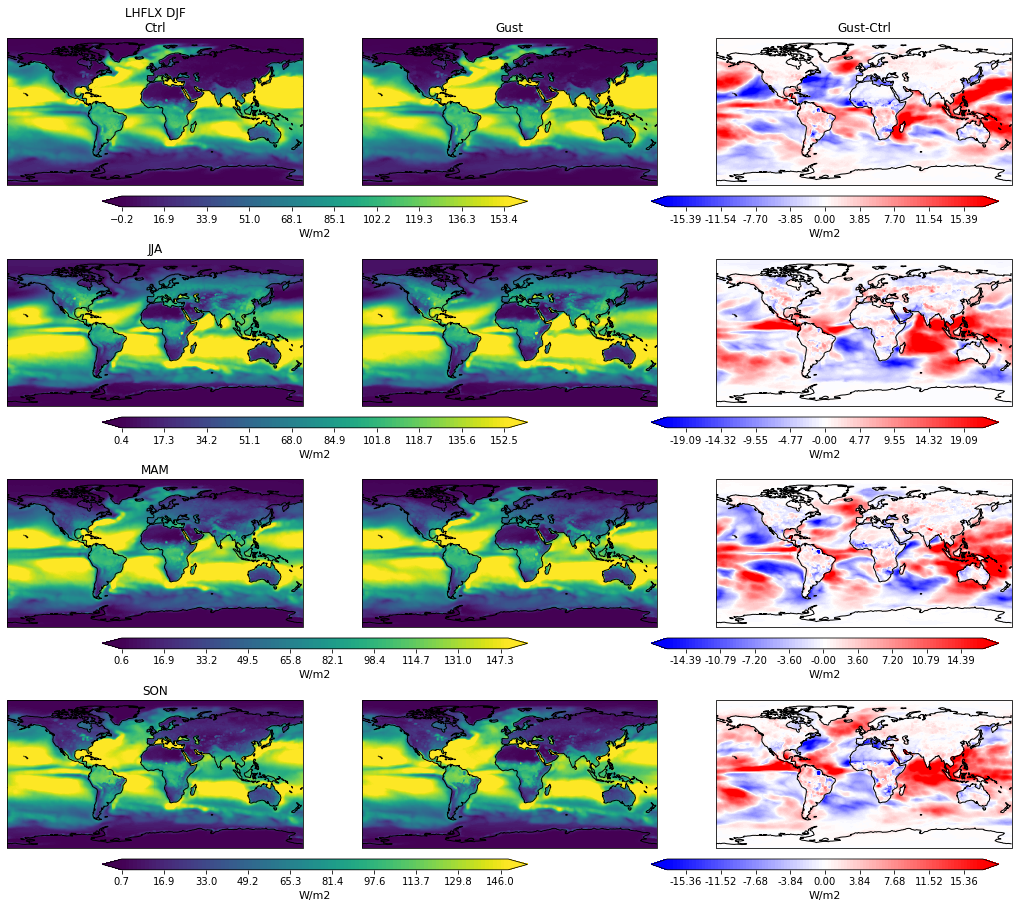

In [15]:
varSel = 'LHFLX'

meanCtrl = seasonalCtrl[varSel]
meanTest = seasonalGust[varSel]

DSctrl = ctrlDS
DStest = gustDS

## Set up figure
fig,axs = plt.subplots(4,3, figsize=(18,15),
                      subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()  
fig.subplots_adjust(hspace=0.45, wspace=0.2)
        
iPlot = 0 
for iSeason in range(4):
    ## Plot raw values
    cMax  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 90), np.nanpercentile(meanTest[iSeason,:,:], 90)])
    cMin  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 10), np.nanpercentile(meanTest[iSeason,:,:], 10)])
    cStep = (cMax - cMin)/100.0

    contour_plot = axs[0+iPlot].contourf(DSctrl.lon.values, DSctrl.lat.values,
                                   meanCtrl[iSeason,:,:],
                                   np.arange(cMin, cMax+cStep, cStep), extend='both')

    contour_plot = axs[1+iPlot].contourf(DStest.lon.values, DStest.lat.values, 
                                   meanTest[iSeason,:,:],
                                   np.arange(cMin, cMax+cStep, cStep),extend='both')

     # Add colorbar
    ax_position = axs[1+iPlot].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.02, ax_position.width+0.1, 0.01])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    if hasattr(DSctrl[varSel], 'units'):
        cbar.set_label(DSctrl[varSel].units,fontsize=11)

     ## Plot difference 
    diffVar = meanTest[iSeason,:,:] - meanCtrl[iSeason,:,:]

    cMax      = np.nanpercentile(diffVar, 98) 
    cMin      = np.nanpercentile(diffVar, 2)
    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    contour_plot = axs[2+iPlot].contourf(DStest.lon.values, DStest.lat.values, 
                    diffVar, 
                    np.arange(-evenPoint, evenPoint+cStep, cStep), 
                    cmap='bwr',extend='both')
    # Add colorbar
    ax_position = axs[2+iPlot].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.02, ax_position.width+0.04, 0.01])
    if varSel=='Q':
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
    else:
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
    if hasattr(DSctrl[varSel], 'units'):
        cbar.set_label(DSctrl[varSel].units,fontsize=11)

    axs[0+iPlot].coastlines()
    axs[1+iPlot].coastlines()
    axs[2+iPlot].coastlines()

    if iSeason==0:
        axs[0+iPlot].set_title(varSel+' '+meanCtrl.season.values[iSeason]+'\nCtrl')
        axs[1+iPlot].set_title('Gust')
        axs[2+iPlot].set_title('Gust-Ctrl')
    else: 
        axs[0+iPlot].set_title(meanCtrl.season.values[iSeason])


    iPlot = iPlot+3


In [13]:
def plot_seasonContourDiff(DSctrl, DSgust, varSel, iSeason):
    
    meanCtrl = DSctrl[varSel]
    meanTest = DSgust[varSel]


    ## Set up figure
    fig,axs = plt.subplots(1,1, figsize=(15,12),
                          subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

     ## Plot difference 
    diffVar = meanTest[iSeason,:,:] - meanCtrl[iSeason,:,:]

    cMax      = np.nanpercentile(diffVar, 98) 
    cMin      = np.nanpercentile(diffVar, 2)
    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0

    contour_plot = axs.contourf(DSctrl.lon.values, DSctrl.lat.values, 
                    diffVar, 
                    np.arange(-evenPoint, evenPoint+cStep, cStep), 
                    cmap='bwr',extend='both',
                    transform=ccrs.PlateCarree())

    # Add colorbar
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.02, ax_position.width+0.04, 0.01])
    if ((varSel=='QREFHT') | (varSel=='PRECC') | (varSel=='PRECT')):
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
    else:
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
        
    if hasattr(ctrlDS[varSel], 'units'):
        cbar.set_label(ctrlDS[varSel].units,fontsize=11)

    axs.coastlines()

    # ocns.plot_regions(ax=axs,label="abbrev", line_kws=dict(lw=1))
#     ocns.plot_regions(ax=axs, line_kws=dict(lw=1))

    axs.set_title(varSel+' '+meanCtrl.season.values[iSeason]+'\nGust-Ctrl')


    return axs 
    

<GeoAxesSubplot:title={'center':'U10 DJF\nGust-Ctrl'}>

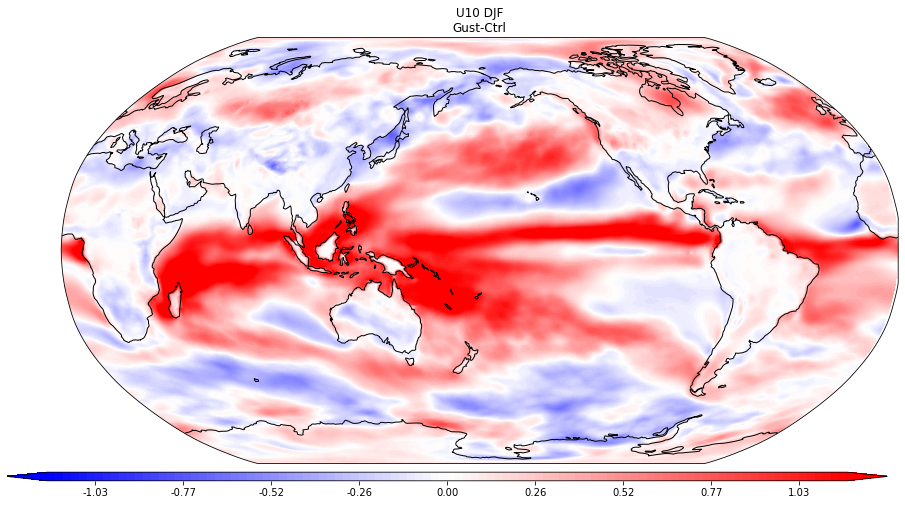

In [60]:
plot_seasonContourDiff(seasonalCtrl, seasonalGust, 'U10', 0)

<GeoAxesSubplot:title={'center':'LHFLX JJA\nGust-Ctrl'}>

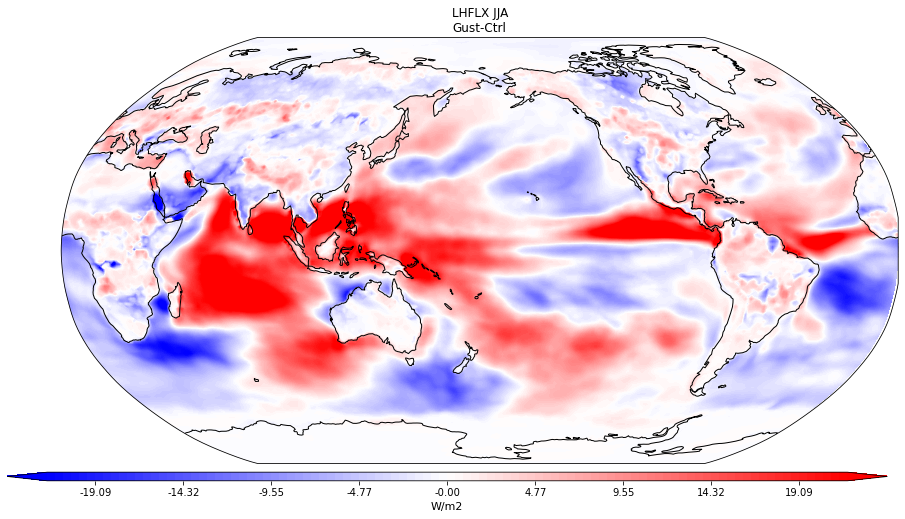

In [15]:
plot_seasonContourDiff(seasonalCtrl, seasonalGust, 'LHFLX', 1)

<GeoAxesSubplot:title={'center':'LHFLX JJA\nGust-Ctrl'}>

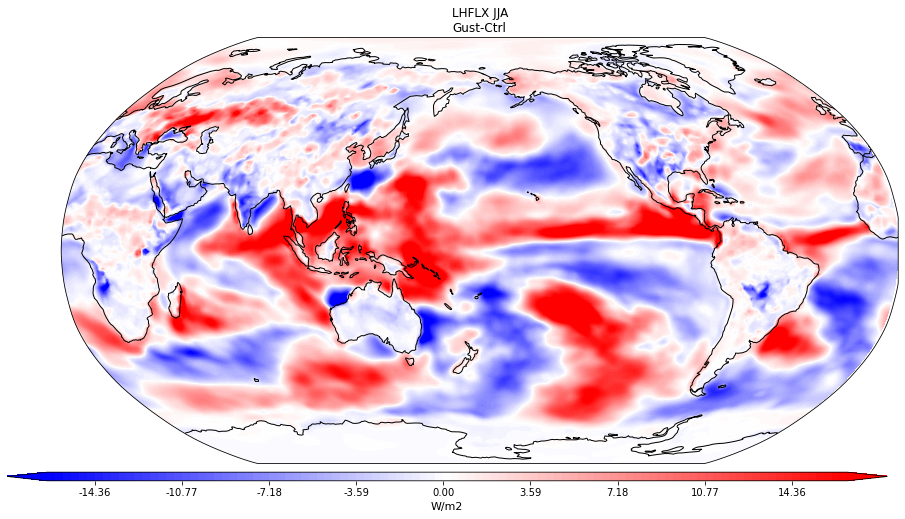

In [16]:
plot_seasonContourDiff(seasonalCtrl58, seasonalGust58, 'LHFLX', 1)

## Focus in particular regions

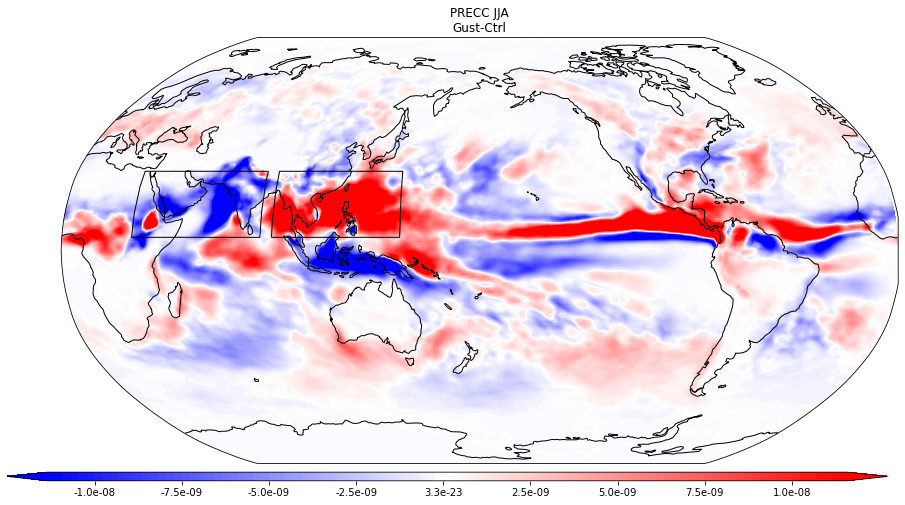

In [95]:
axs = plot_seasonContourDiff(seasonalCtrl, seasonalGust, 'PRECC', 1)

#SE Asian Monsoon? 
# axs.add_patch(
#      patches.Rectangle(xy=[30, 5], width=55, height=25,
#                                     edgecolor='k',
#                                     facecolor='none',
#                                     transform=ccrs.PlateCarree()) )

# Tropical West Pacific?
axs.add_patch(
     patches.Rectangle(xy=[90, 5], width=55, height=25,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree()) )



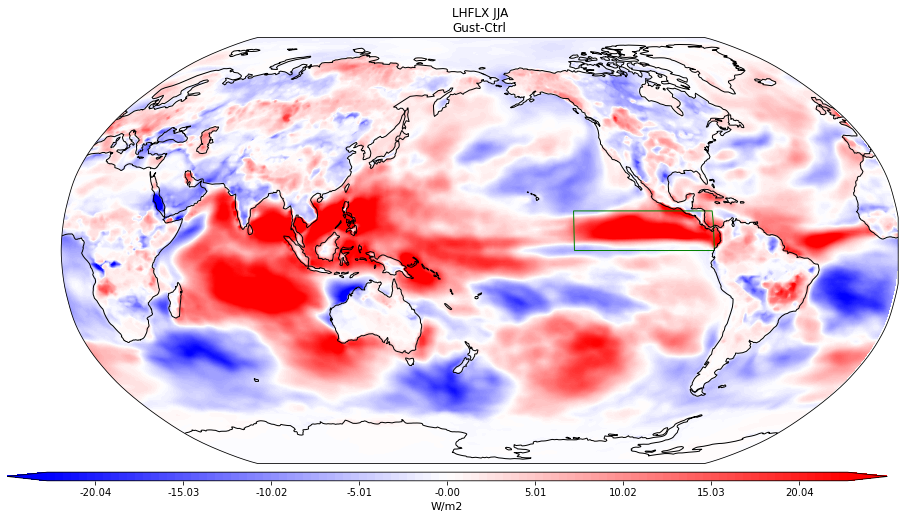

In [16]:
# axs = plot_seasonContourDiff(seasonalCtrl, seasonalGust, 'PRECC', 1)
axs = plot_seasonContourDiff(seasonalCtrl, seasonalGust, 'LHFLX', 1)
# axs = plot_seasonContourDiff(seasonalCtrl58, seasonalGust58, 'LHFLX', 1)


# #SE Asian Monsoon? 
# axs.add_patch(
#      patches.Rectangle(xy=[30, 5], width=55, height=25,
#                                     edgecolor='k',
#                                     facecolor='none',

#                                     transform=ccrs.PlateCarree()) )

# # Tropical West Pacific?
# axs.add_patch(
#      patches.Rectangle(xy=[90, 5], width=55, height=25,
#                                     edgecolor='k',
#                                     facecolor='none',

#                                     transform=ccrs.PlateCarree()) )


# # Tropical West Pacific?
# axs.add_patch(
#      patches.Rectangle(xy=[92, -10], width=90, height=35,
#                                     edgecolor='g',
#                                     facecolor='none',

#                                     transform=ccrs.PlateCarree()) )

# # Eastern South Pacific?
# axs.add_patch(
#      patches.Rectangle(xy=[200, -65], width=75, height=50,
#                                     edgecolor='g',
#                                     facecolor='none',

#                                     transform=ccrs.PlateCarree()) )

# Eastern tropical pacific?
axs.add_patch(
     patches.Rectangle(xy=[220, 0], width=60, height=15,
                                    edgecolor='g',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree()) )


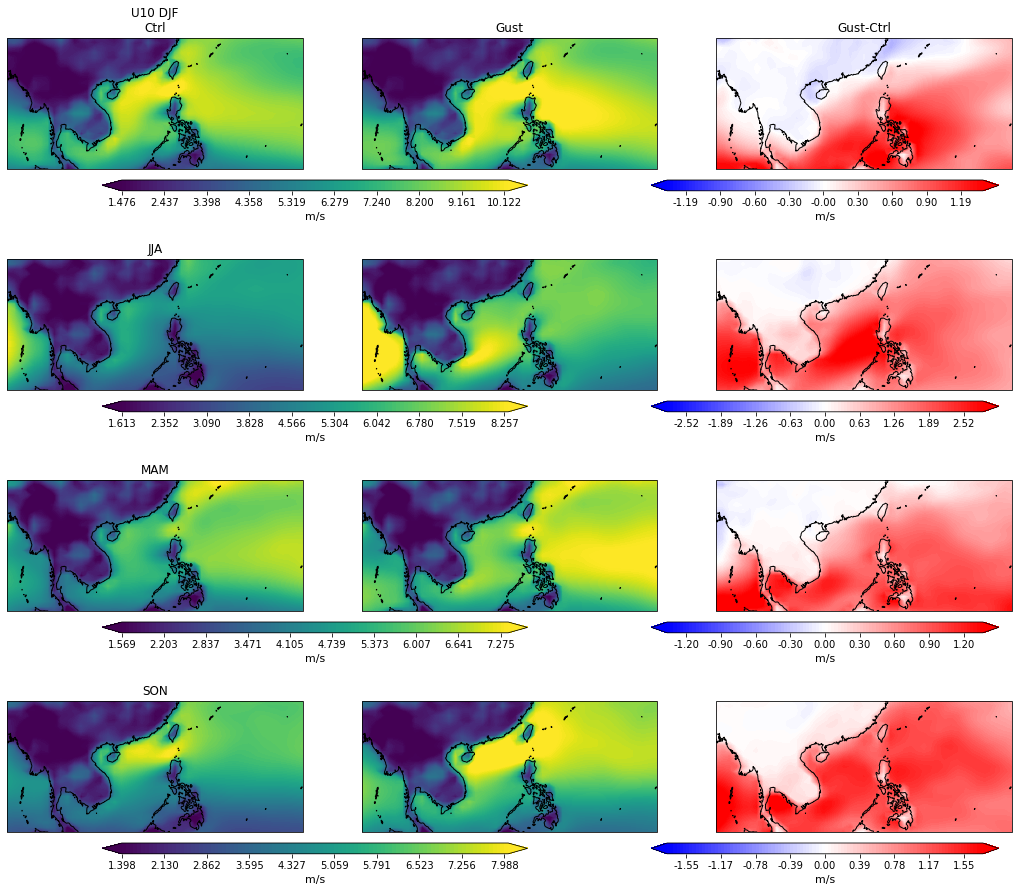

In [11]:
varSel = 'U10'

iLat    = np.where((ctrlDS['lat'].values>=5) & (ctrlDS['lat'].values<=(5+25)))[0]
iLon    = np.where((ctrlDS['lon'].values>=90) & (ctrlDS['lon'].values<=(90+55)))[0]
    
    
# meanCtrl = (landMask*seasonalCtrl[varSel]).isel(lat=iLat, lon=iLon)
# meanTest = (landMask*seasonalGust[varSel]).isel(lat=iLat, lon=iLon)
meanCtrl = (seasonalCtrl[varSel]).isel(lat=iLat, lon=iLon)
meanTest = (seasonalGust[varSel]).isel(lat=iLat, lon=iLon)

DSctrl = ctrlDS
DStest = gustDS

## Set up figure
fig,axs = plt.subplots(4,3, figsize=(18,15),
                      subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()  
fig.subplots_adjust(hspace=0.45, wspace=0.2)
        
iPlot = 0 
for iSeason in range(4):
    ## Plot raw values
    cMax  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 80), np.nanpercentile(meanTest[iSeason,:,:], 95)])
    cMin  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 5), np.nanpercentile(meanTest[iSeason,:,:], 5)])
    cStep = (cMax - cMin)/100.0

    contour_plot = axs[0+iPlot].contourf(DSctrl.lon.values[iLon], DSctrl.lat.values[iLat],
                                   meanCtrl[iSeason,:,:],
                                   np.arange(cMin, cMax+cStep, cStep), extend='both')

    contour_plot = axs[1+iPlot].contourf(DStest.lon.values[iLon], DStest.lat.values[iLat], 
                                   meanTest[iSeason,:,:],
                                   np.arange(cMin, cMax+cStep, cStep),extend='both')

     # Add colorbar
    ax_position = axs[1+iPlot].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.02, ax_position.width+0.1, 0.01])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    if hasattr(DSctrl[varSel], 'units'):
        cbar.set_label(DSctrl[varSel].units,fontsize=11)

     ## Plot difference 
    diffVar = meanTest[iSeason,:,:] - meanCtrl[iSeason,:,:]

    cMax      = np.nanpercentile(diffVar, 98) 
    cMin      = np.nanpercentile(diffVar, 2)
    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    contour_plot = axs[2+iPlot].contourf(DStest.lon.values[iLon], DStest.lat.values[iLat], 
                    diffVar, 
                    np.arange(-evenPoint, evenPoint+cStep, cStep), 
                    cmap='bwr',extend='both')
    # Add colorbar
    ax_position = axs[2+iPlot].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.02, ax_position.width+0.04, 0.01])
    if varSel=='Q':
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
    else:
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
    if hasattr(DSctrl[varSel], 'units'):
        cbar.set_label(DSctrl[varSel].units,fontsize=11)

    axs[0+iPlot].coastlines()
    axs[1+iPlot].coastlines()
    axs[2+iPlot].coastlines()

    if iSeason==0:
        axs[0+iPlot].set_title(varSel+' '+meanCtrl.season.values[iSeason]+'\nCtrl')
        axs[1+iPlot].set_title('Gust')
        axs[2+iPlot].set_title('Gust-Ctrl')
    else: 
        axs[0+iPlot].set_title(meanCtrl.season.values[iSeason])


    iPlot = iPlot+3



In [15]:
'''
Note: Obs data is assumed to already be filtered to the months and lat/lon selected, and reshaped to 1D. 
'''

def pdfs_seasonalRegional(minLat, maxLat, minLon, maxLon, 
                          monthStart, monthEnd, maskSel,
                          varSel, 
                          obsData, obsName): 
    
    iMonths = np.where((ctrlDS['time.month'].values>=monthStart) & (ctrlDS['time.month'].values<=monthEnd))[0]
    iLat    = np.where((ctrlDS['lat'].values>=minLat) & (ctrlDS['lat'].values<=maxLat))[0]
    iLon    = np.where((ctrlDS['lon'].values>=minLon) & (ctrlDS['lon'].values<=maxLon))[0]
    
    
    iMonths58 = np.where((ctrl58['time.month'].values>=monthStart) & (ctrl58['time.month'].values<=monthEnd))[0]
    iLat58    = np.where((ctrl58['lat'].values>=minLat) & (ctrl58['lat'].values<=maxLat))[0]
    iLon58    = np.where((ctrl58['lon'].values>=minLon) & (ctrl58['lon'].values<=maxLon))[0]
    
    
    # Apply land/sea mask if requested
    # - - - - - - - - - - - - - - - - -
    if maskSel=='oceanOnly':
        ## 32L
        maskVar_ctrl = ctrlDS[varSel]*oceanMask
        maskVar_gust = gustDS[varSel]*oceanMask
        
        sel_ctrl = maskVar_ctrl.isel(time=iMonths, lat=iLat, lon=iLon) 
        sel_gust = maskVar_gust.isel(time=iMonths, lat=iLat, lon=iLon)
        
        ## 58L
        maskVar_ctrl58 = ctrl58[varSel]*oceanMask58
        maskVar_gust58 = gust58[varSel]*oceanMask58
        
        sel_ctrl58 = maskVar_ctrl58.isel(time=iMonths58, lat=iLat58, lon=iLon58) 
        sel_gust58 = maskVar_gust58.isel(time=iMonths58, lat=iLat58, lon=iLon58)
        
        maskStr = maskSel
    elif maskSel=='landOnly':
        ## 32L
        maskVar_ctrl = ctrlDS[varSel]*landMask
        maskVar_gust = gustDS[varSel]*landMask
        
        sel_ctrl = maskVar_ctrl.isel(time=iMonths, lat=iLat, lon=iLon) 
        sel_gust = maskVar_gust.isel(time=iMonths, lat=iLat, lon=iLon) 
        
        ## 58L
        maskVar_ctrl58 = ctrl58[varSel]*landMask58
        maskVar_gust58 = gust58[varSel]*landMask58
        
        sel_ctrl58 = maskVar_ctrl58.isel(time=iMonths58, lat=iLat58, lon=iLon58) 
        sel_gust58 = maskVar_gust58.isel(time=iMonths58, lat=iLat58, lon=iLon58)
        
        maskStr = maskSel
    elif maskSel=='both':
        ## 32L 
        sel_ctrl = ctrlDS[varSel].isel(time=iMonths, lat=iLat, lon=iLon)
        sel_gust = gustDS[varSel].isel(time=iMonths, lat=iLat, lon=iLon) 
        
        ## 58L
        sel_ctrl58 = ctrl58[varSel].isel(time=iMonths58, lat=iLat58, lon=iLon58) 
        sel_gust58 = gust58[varSel].isel(time=iMonths58, lat=iLat58, lon=iLon58)        
        
        maskStr = 'Land+Ocean'
    else:
        print('Please select a valid option for masking: oceanOnly, landOnly, or both')
        
    ## Compute time mean first 
    sel_ctrl = sel_ctrl.mean(dim='time')
    sel_gust = sel_gust.mean(dim='time')
    
    sel_ctrl58 = sel_ctrl58.mean(dim='time')
    sel_gust58 = sel_gust58.mean(dim='time')
        
        
    # For sanity check, plot the time mean difference    
    # - - - - - - - - - - - - - - - - -
    fig,axs = plt.subplots(2,2,figsize=(20,15), subplot_kw={'projection':ccrs.Robinson()})
    axs = axs.ravel()
    
    cMax      = np.nanpercentile([sel_ctrl], 98) 
    cMin      = np.nanpercentile([sel_ctrl], 2)
    cMax58    = np.nanpercentile([sel_ctrl58], 98) 
    cMin58    = np.nanpercentile([sel_ctrl58], 2)
    cmax_plot = np.nanmax([cMax, cMax58])
    cmin_plot = np.nanmin([cMin, cMin58])
    
    contour_plot = axs[0].contourf(sel_ctrl.lon.values, sel_ctrl.lat.values, 
                    sel_ctrl, 
                    np.arange(cmin_plot, cmax_plot, (cmax_plot-cmin_plot)/100.0), 
                    cmap='gnuplot2',extend='both',
                    transform=ccrs.PlateCarree())
    
    contour_plot = axs[1].contourf(sel_ctrl58.lon.values, sel_ctrl58.lat.values, 
                    sel_ctrl58, 
                    np.arange(cmin_plot, cmax_plot, (cmax_plot-cmin_plot)/100.0), 
                    cmap='gnuplot2',extend='both',
                    transform=ccrs.PlateCarree())
    
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.25, ax_position.y0-0.02, ax_position.width+0.1, 0.01])
    if ((varSel=='QREFHT') | (varSel=='PRECC') | (varSel=='PRECT')):
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
    else:
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
        
    if hasattr(ctrlDS[varSel], 'units'):
        cbar.set_label(ctrlDS[varSel].units,fontsize=11)

    axs[0].coastlines()
    axs[0].set_title(varSel+'\nCtrl (32L)')    
    axs[1].coastlines()
    axs[1].set_title(varSel+'\nCtrl (58L)')  
    
    ## Plot difference
        
    # diffVar = sel_gust.mean(dim='time') - sel_ctrl.mean(dim='time')
    diffVar   = sel_gust - sel_ctrl
    diffVar58 = sel_gust58 - sel_ctrl58

    cMax      = np.nanpercentile([diffVar], 98) 
    cMin      = np.nanpercentile([diffVar], 2)
    cMax58    = np.nanpercentile([diffVar58], 98) 
    cMin58    = np.nanpercentile([diffVar58], 2)
    
    evenPoint = np.nanmax([abs(cMax),abs(cMax58),abs(cMin),abs(cMin58)]) 
    cStep     = (evenPoint*2)/100.0

    contour_plot = axs[2].contourf(sel_ctrl.lon.values, sel_ctrl.lat.values, 
                    diffVar, 
                    np.arange(-evenPoint, evenPoint+cStep, cStep), 
                    cmap='bwr',extend='both',
                    transform=ccrs.PlateCarree())
    
    contour_plot = axs[3].contourf(sel_ctrl58.lon.values, sel_ctrl58.lat.values, 
                    diffVar58, 
                    np.arange(-evenPoint, evenPoint+cStep, cStep), 
                    cmap='bwr',extend='both',
                    transform=ccrs.PlateCarree())

    # Add colorbar
    ax_position = axs[3].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.25, ax_position.y0-0.02, ax_position.width+0.1, 0.01])
    if ((varSel=='QREFHT') | (varSel=='PRECC') | (varSel=='PRECT')):
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
    else:
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
        
    if hasattr(ctrlDS[varSel], 'units'):
        cbar.set_label(ctrlDS[varSel].units,fontsize=11)

    axs[2].coastlines()
    axs[2].set_title(varSel+'\nGust-Ctrl (32L)')    
    axs[3].coastlines()
    axs[3].set_title(varSel+'\nGust-Ctrl (58L)')  
    
    
    ## Reshape to 1D 
    # - - - - - - - - - - - - - - - - -
    #nD = len(iMonths)*len(iLat)*len(iLon)
    nD = len(iLat)*len(iLon)
    nD58 = len(iLat58)*len(iLon58)
    
    ctrl_1d = np.reshape(sel_ctrl.values, [nD])
    gust_1d = np.reshape(sel_gust.values, [nD])
    
    ctrl_1d58 = np.reshape(sel_ctrl58.values, [nD58])
    gust_1d58 = np.reshape(sel_gust58.values, [nD58])
    
    df = pd.concat(axis=0, ignore_index=True, objs=[
            pd.DataFrame.from_dict({varSel: ctrl_1d, 'case': 'CTRL_32L'}),
            pd.DataFrame.from_dict({varSel: gust_1d, 'case': 'GUST_32L'}),
            pd.DataFrame.from_dict({varSel: ctrl_1d58, 'case': 'CTRL_58L'}),
            pd.DataFrame.from_dict({varSel: gust_1d58, 'case': 'GUST_58L'}),
            ])

            
    # Make plot 
    # - - - - - - - - - - - - - - - - -
        
    if obsName!=None:         
        g = sns.displot(df, x=varSel, hue='case', kind='kde', height=6, cut=0, 
                    palette=['mediumblue','firebrick','deepskyblue','red'], legend=False)
        
        ax2 = plt.twinx()
        g2 = sns.kdeplot(obsData, ax=ax2, color='black')
        ax2.set_ylabel('Obs: '+obsName)
    else:
        g = sns.displot(df, x=varSel, hue='case', kind='kde', height=6, cut=0, 
                    palette=['mediumblue','firebrick','deepskyblue','red'])
        plt.setp(g._legend.get_title(), fontsize=12)
        plt.setp(g._legend.get_texts(), fontsize=12)
        

    g.ax.set_title("JJA mean "+varSel+" (months "+str(monthStart)+"-"+str(monthEnd)+")\n"+maskStr, fontsize=16 ) 
    g.ax.set_xlabel(ctrlDS[varSel].units,fontsize=14)
    g.ax.set_ylabel('Density',fontsize=14)
    g.ax.tick_params(axis='both', labelsize= 12)
    
    plt.show()
    
    return plt

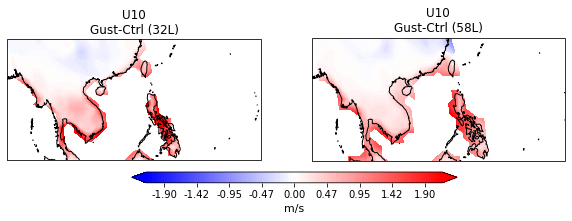

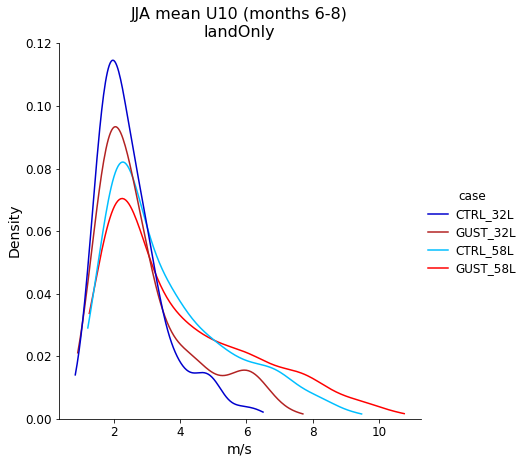

In [46]:
p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'landOnly',
                           'U10',
                           None, None)


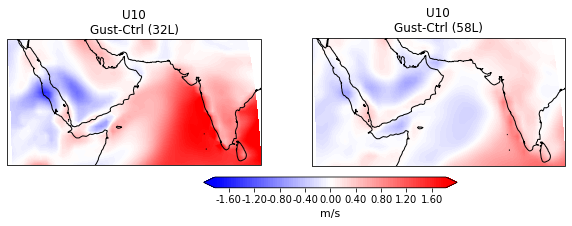

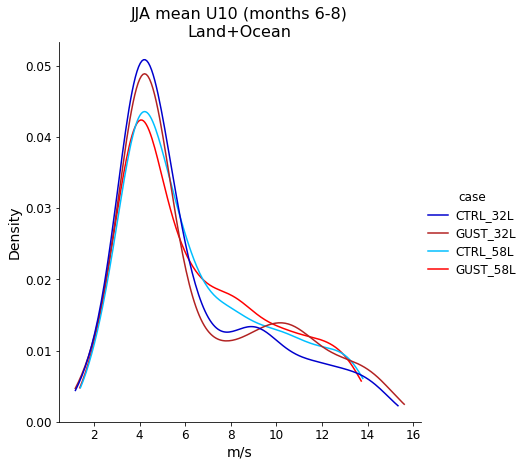

In [31]:
p1 = pdfs_seasonalRegional(5,  5+25, 
                           30, 30+55, 
                           6, 8, 
                           'both',
                           'U10',
                           None, None)


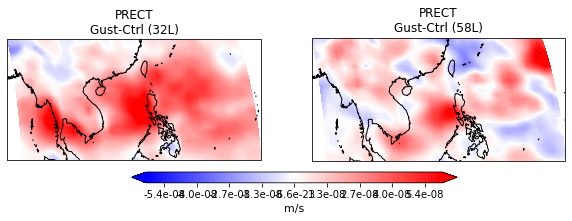

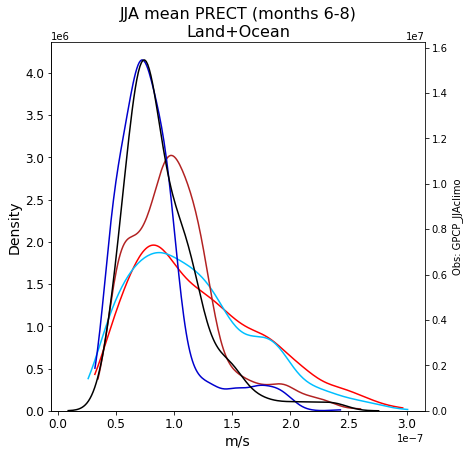

In [47]:
## Add obs for PRECT? 
gpcp_jja_convert = gpcp_jja.PRECT.values / 86400000.0   # Convert from mm/day to m/s 

# Select the NW Pac region of interest 
iLat    = np.where((gpcp_jja['lat'].values>=5) & (gpcp_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((gpcp_jja['lon'].values>=90) & (gpcp_jja['lon'].values<=(90+55)))[0]

gpcp_selRegion = gpcp_jja_convert[0, iLat, :]
gpcp_selRegion = gpcp_selRegion[:, iLon]

# Reshape to 1D 
gpcp_selRegion = np.reshape(gpcp_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'PRECT',
                           gpcp_selRegion, 'GPCP_JJAclimo')

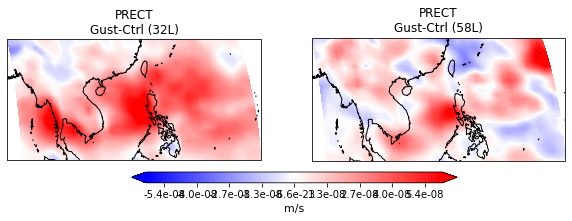

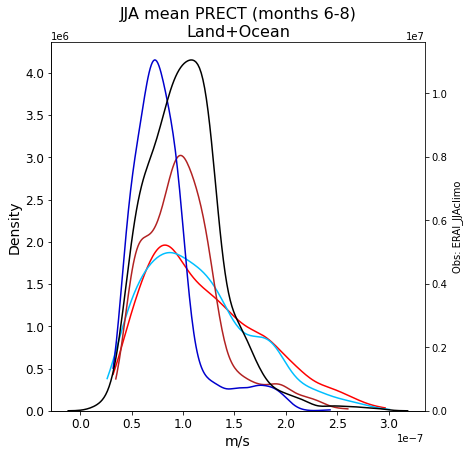

In [48]:
## Add obs for PRECT? 
erai_jja_convert = erai_jja.PRECT.values / 86400000.0   # Convert from mm/day to m/s 

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=5) & (erai_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_jja['lon'].values>=90) & (erai_jja['lon'].values<=(90+55)))[0]

erai_selRegion = erai_jja_convert[0, iLat, :]
erai_selRegion = erai_selRegion[:, iLon]

# Reshape to 1D 
erai_selRegion = np.reshape(erai_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'PRECT',
                           erai_selRegion, 'ERAI_JJAclimo')

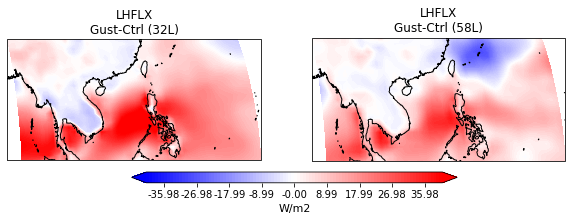

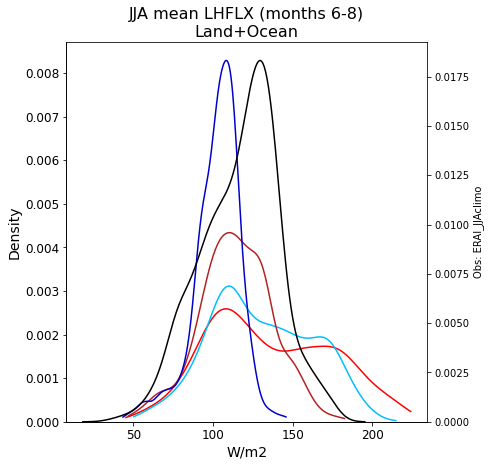

In [49]:
## Add obs for LHFLX? 
lhflx_jja = erai_jja.LHFLX.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=5)  & (erai_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_jja['lon'].values>=90) & (erai_jja['lon'].values<=(90+55)))[0]

lhflx_selRegion = lhflx_jja[0, iLat, :]
lhflx_selRegion = lhflx_selRegion[:, iLon]

# Reshape to 1D 
lhflx_selRegion = np.reshape(lhflx_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'LHFLX',
                           lhflx_selRegion, 'ERAI_JJAclimo')

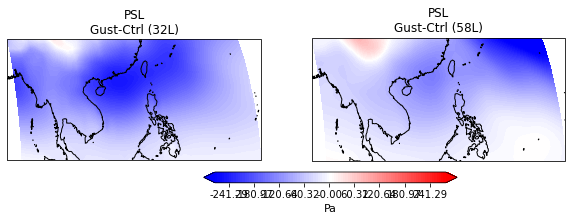

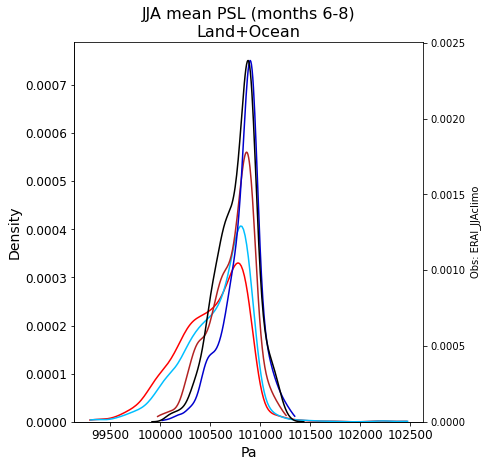

In [40]:
## Add obs for LHFLX? 
psl_jja = erai_jja.PSL.values*100

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=5)  & (erai_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_jja['lon'].values>=90) & (erai_jja['lon'].values<=(90+55)))[0]

psl_selRegion = psl_jja[0, iLat, :]
psl_selRegion = psl_selRegion[:, iLon]

# Reshape to 1D 
psl_selRegion = np.reshape(psl_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'PSL',
                           psl_selRegion, 'ERAI_JJAclimo')

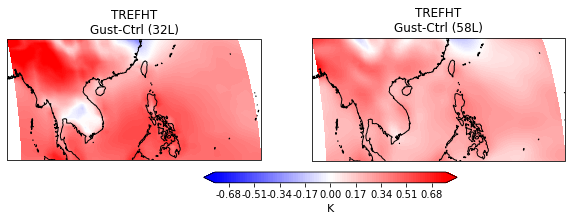

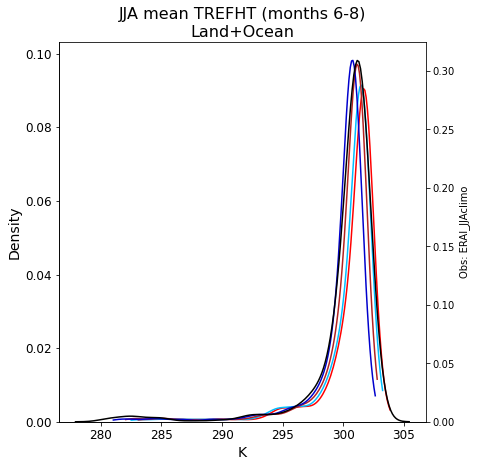

In [34]:
## Add obs for LHFLX? 
trefht_jja = erai_jja.TREFHT.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=5)  & (erai_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_jja['lon'].values>=90) & (erai_jja['lon'].values<=(90+55)))[0]

trefht_selRegion = trefht_jja[0, iLat, :]
trefht_selRegion = trefht_selRegion[:, iLon]

# Reshape to 1D 
trefht_selRegion = np.reshape(trefht_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'TREFHT',
                           trefht_selRegion, 'ERAI_JJAclimo')

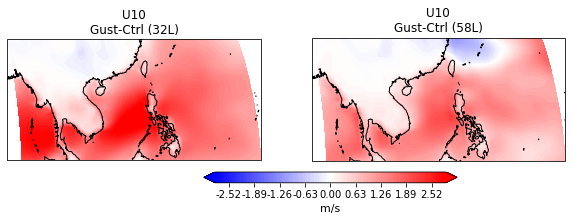

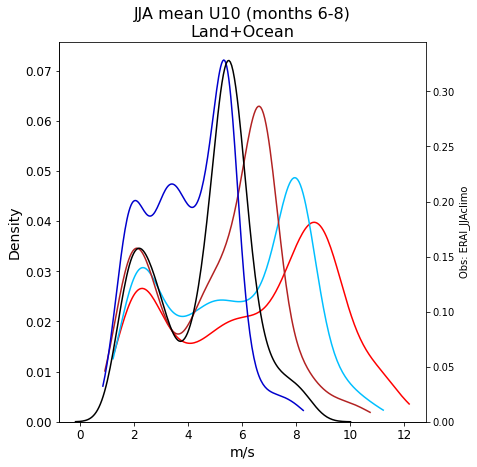

In [35]:
## Add obs for LHFLX? 
u10_jja = erai_jja.WIND_MAG_SURF.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=5)  & (erai_jja['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_jja['lon'].values>=90) & (erai_jja['lon'].values<=(90+55)))[0]

u10_selRegion = u10_jja[0, iLat, :]
u10_selRegion = u10_selRegion[:, iLon]

# Reshape to 1D 
u10_selRegion = np.reshape(u10_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           6, 8, 
                           'both',
                           'U10',
                           u10_selRegion, 'ERAI_JJAclimo')

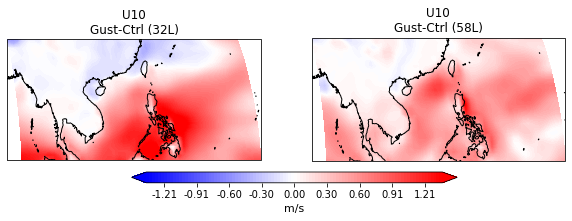

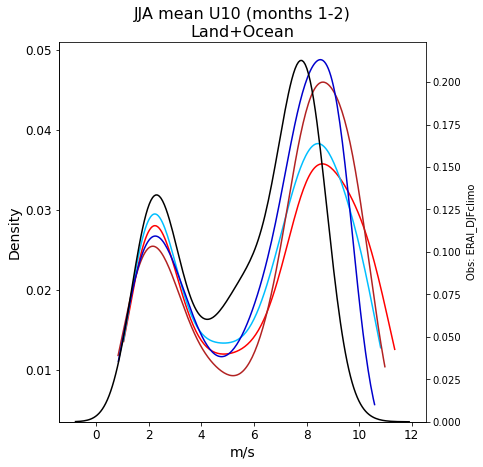

In [50]:
## Add obs for LHFLX? 
u10_djf = erai_djf.WIND_MAG_SURF.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_djf['lat'].values>=5)  & (erai_djf['lat'].values<=(5+25)))[0]
iLon    = np.where((erai_djf['lon'].values>=90) & (erai_djf['lon'].values<=(90+55)))[0]

u10_selRegion = u10_djf[0, iLat, :]
u10_selRegion = u10_selRegion[:, iLon]

# Reshape to 1D 
u10_selRegion = np.reshape(u10_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(5,  5+25, 
                           90, 90+55, 
                           1, 2, 
                           'both',
                           'U10',
                           u10_selRegion, 'ERAI_DJFclimo')

## Tropical oceans

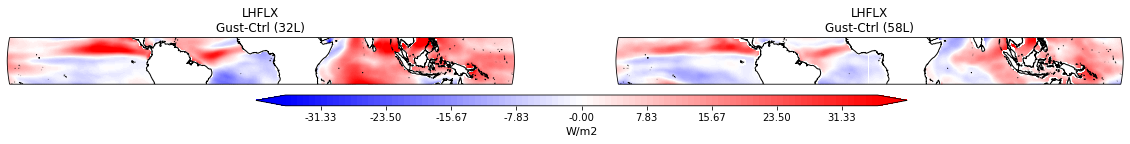

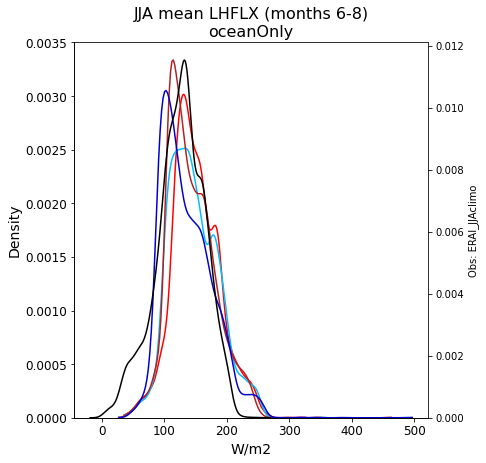

In [55]:
## Add obs for LHFLX? 
lhflx_jja = erai_jja.LHFLX.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=-15)  & (erai_jja['lat'].values<=(15)))[0]

lhflx_selRegion = lhflx_jja[0, iLat, :]

# Reshape to 1D 
lhflx_selRegion = np.reshape(lhflx_selRegion, [len(iLat)*len(erai_jja.lon.values)])

p1 = pdfs_seasonalRegional(-15,  15, 
                           0, 360, 
                           6, 8, 
                           'oceanOnly',
                           'LHFLX',
                           lhflx_selRegion, 'ERAI_JJAclimo')

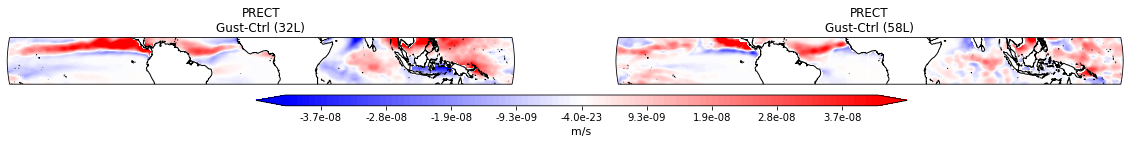

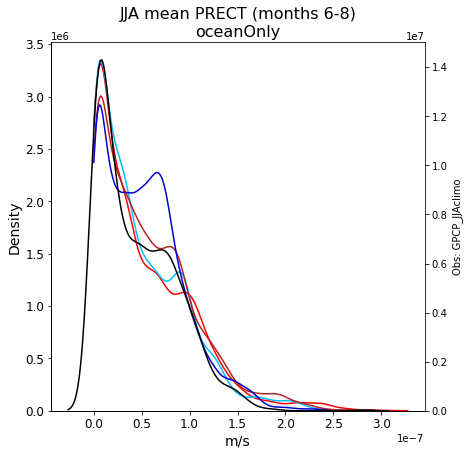

In [59]:
## Add obs for LHFLX? 
gpcp_jja_convert = gpcp_jja.PRECT.values / 86400000.0   # Convert from mm/day to m/s 

# Select the NW Pac region of interest 
iLat    = np.where((gpcp_jja['lat'].values>=-15)  & (gpcp_jja['lat'].values<=(15)))[0]

prect_selRegion = gpcp_jja_convert[0, iLat, :]

# Reshape to 1D 
prect_selRegion = np.reshape(prect_selRegion, [len(iLat)*len(gpcp_jja.lon.values)])

p1 = pdfs_seasonalRegional(-15,  15, 
                           0, 360, 
                           6, 8, 
                           'oceanOnly',
                           'PRECT',
                           prect_selRegion, 'GPCP_JJAclimo')

### South Pacific

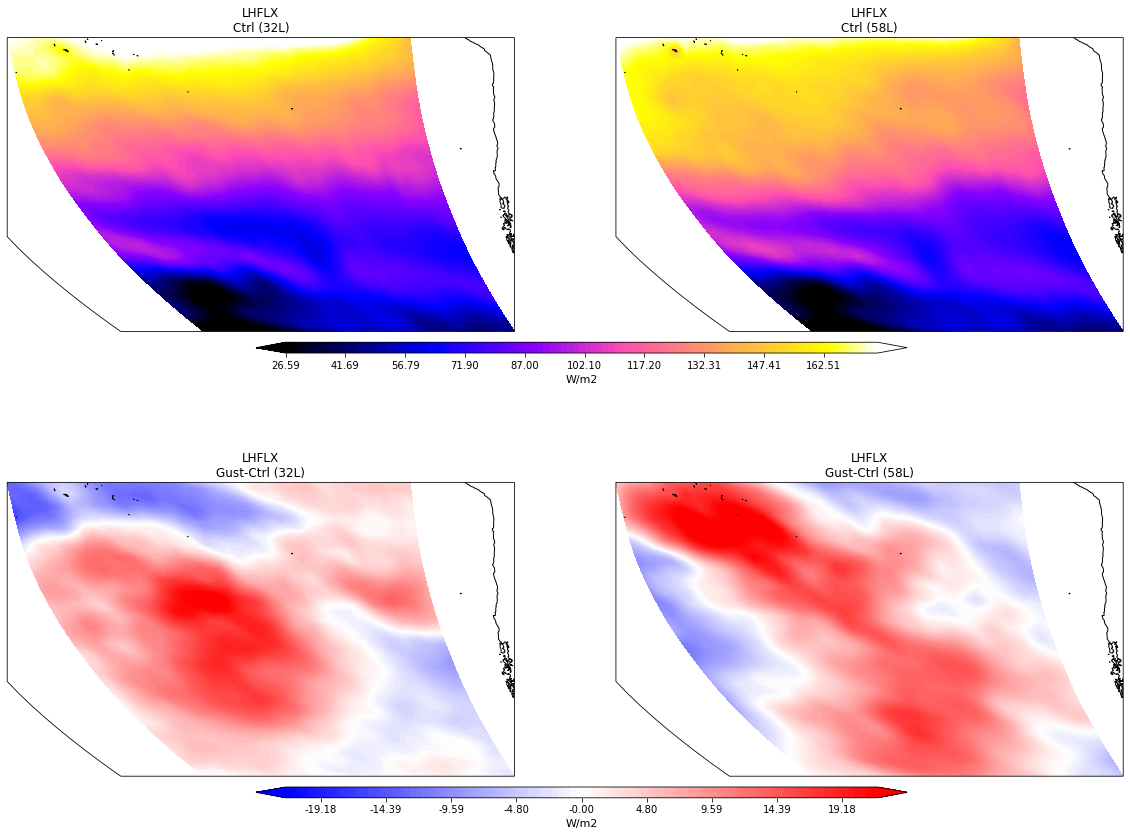

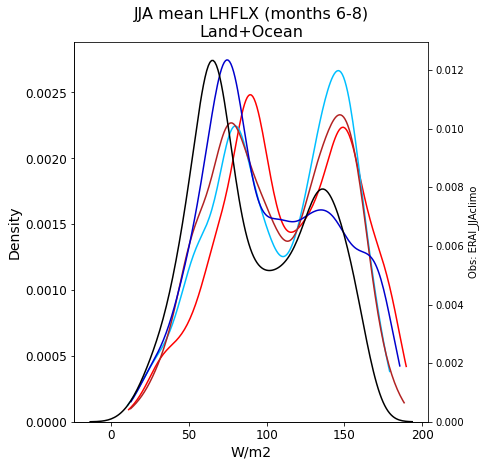

In [16]:
## Add obs for LHFLX? 
lhflx_jja = erai_jja.LHFLX.values

# Select the NW Pac region of interest 
iLat    = np.where((erai_jja['lat'].values>=-65)  & (erai_jja['lat'].values<=(-65+50)))[0]
iLon    = np.where((erai_jja['lon'].values>=200) & (erai_jja['lon'].values<=(200+75)))[0]

lhflx_selRegion = lhflx_jja[0, iLat, :]
lhflx_selRegion = lhflx_selRegion[:, iLon]

# Reshape to 1D 
lhflx_selRegion = np.reshape(lhflx_selRegion, [len(iLat)*len(iLon)])

p1 = pdfs_seasonalRegional(-65,  -65+50, 
                           200, 200+75, 
                           6, 8, 
                           'both',
                           'LHFLX',
                           lhflx_selRegion, 'ERAI_JJAclimo')